In [1]:
import math, sys, os
import time
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
from plotter import *
from kalman import *
from motion import *

%matplotlib notebook

In [2]:
# Import tdmclient Notebook environment:
import tdmclient.notebook
await tdmclient.notebook.start()

In [3]:
%%run_python

state = 1

@onevent
def move(speed_left, speed_right):
    global motor_left_target, motor_right_target, state
    if state == 1 :
        motor_left_target = speed_left
        motor_right_target = speed_right
    
@onevent 
def button_center():
    global state, motor_left_target, motor_right_target
    state = 0
    motor_left_target = 0
    motor_right_target = 0

In [4]:
def send_command():
    if optimal_command[step][0] == optimal_command[step][1] and optimal_command[step][0] != 0:
        send_event("move", optimal_command[step][0] + 2, optimal_command[step][1] - 2)
    else :
        send_event("move", optimal_command[step][0], optimal_command[step][1])

In [5]:
@tdmclient.notebook.sync_var
def get_speed():
    return motor_left_speed, motor_right_speed

def kalman_call():
    global step, x_est, start, rt
    
    if step < len(optimal_command) and camera_on != True:
        #retrieves the equivalent of the command that was applied Ts seconds ago
        speed_left = optimal_command[step][0]
        speed_right = optimal_command[step][1]

        #gets the right matrix corresponding to the command :
        #Thymio goes forward
        if speed_left == speed_right :
            Q = Q_F
            R = R_F
            A = A_F

        #Thymio is rotating
        else :
            Q = Q_R
            R = R_R
            A = A_R


        #measures the speed of the robot
        meas_speed_left,  meas_speed_right = get_speed()

        #computes the estimated states
        new_x_est, new_P_est = kalman_filter(meas_speed_left, meas_speed_right, x_est[-1], P_est[-1], Q, R, A)

        x_est.append(new_x_est)
        P_est.append(new_P_est)

        step += 1

        if step < len(optimal_command) :
            send_command()
    else :
        rt.stop()

<IPython.core.display.Javascript object>


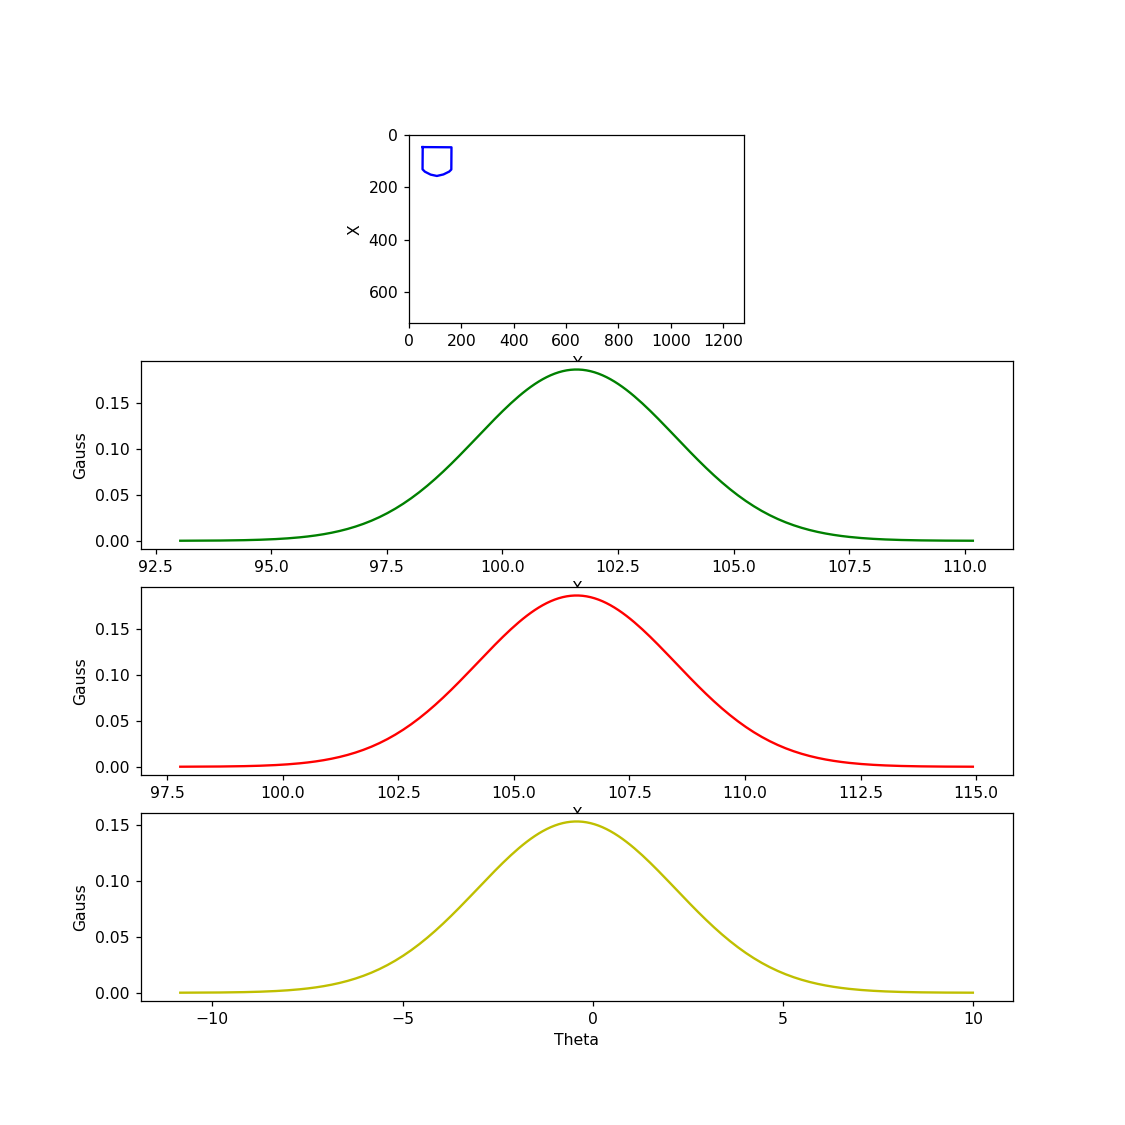

In [6]:
camera_on = False

#initial state, robot stopped :
x0 = 100
y0 = 100
theta0 = 0

x_dot0 = 0 
y_dot0 = 0
theta_dot0 = 0 

x_est = [np.array([[x0], [y0], [theta0], [x_dot0], [y_dot0], [theta_dot0]])]
P_est = [np.diag(np.array([2**2, 2**2, (2 * (math.pi/180)) ** 2, 0, 0, 0]))]

step = 0
optimal_command = turn_left(math.pi/2) + move_forward(30) +  move_backward(30) + turn_right(math.pi/2) + [[0, 0]]

#start Kalman
send_command()
rt = RepeatedTimer(Ts, kalman_call)


#fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(4,1,1)
ax2 = fig.add_subplot(4,1,2)
ax3 = fig.add_subplot(4,1,3)
ax4 = fig.add_subplot(4,1,4)


while step < len(optimal_command) and camera_on != True:
    plot(ax1, ax2, ax3, ax4, x_est, P_est, fig)
    #time.sleep(0.1)
    
plot(ax1, ax2, ax3, ax4, x_est, P_est, fig)

